# RESULTS NMNIST

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ../hots
import tonic, torch, os, pickle, copy
from tqdm import tqdm
from network import network
from layer import mlrlayer
from timesurface import timesurface
from utils import apply_jitter, get_loader, make_histogram_classification, HOTS_Dataset, fit_mlr, predict_mlr, score_classif_events, plotjitter, printfig, online_accuracy
import matplotlib.pyplot as plt
import numpy as np

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')
    
record_path = '/envau/work/neopto/USERS/GRIMALDI/HOTS/hotsline/Records/'
#record_path = '../Records/' #-> default if not mentionned

/home/INT/grimaldi.a/Documents/projets/HOTS/hotsline/hots
Tonic version installed -> 1.2.1
Number of GPU devices available: 1
GPU 1 named Quadro RTX 5000


## Loading of the dataset for the clustering phase

In [3]:
kfold = None
device = 'cpu'

type_transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.NMNIST(save_to='../../Data/', train=True, transform=type_transform)
testset = tonic.datasets.NMNIST(save_to='../../Data/', train=False, transform=type_transform)
loader = get_loader(trainset, kfold=300)
trainloader = get_loader(trainset, kfold=kfold)
testloader = get_loader(testset, kfold=kfold)
num_sample_train = len(trainloader)
num_sample_test = len(testloader)
n_classes = len(testset.classes)
print(f'number of samples in the training set: {len(trainloader)}')
print(f'number of samples in the testing set: {len(testloader)}')

number of samples in the training set: 60000
number of samples in the testing set: 10000


## Initialization of the network

In [4]:
name = 'homeohots'
homeo = True
timestr = '2022-06-15'
dataset_name = 'nmnist'

Rz = [2, 4]
N_neuronz = [16, 32]
tauz = [1e4*2, 1e4*16]

hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo, record_path = record_path)

initial_name = copy.copy(hots.name)

name_nohomeo = 'hots'
hots_nohomeo = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = False, record_path = record_path)

initial_name_nohomeo = copy.copy(hots_nohomeo.name)

In [5]:
hots.name

'2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]'

## Unsupervised clustering

In [6]:
filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
if not os.path.exists(hots.record_path):
    os.mkdir(hots.record_path)
    os.mkdir(hots.record_path+'networks/')
path = hots.record_path+'networks/'+hots.name+'.pkl'
if not os.path.exists(path):
    hots.clustering(loader, trainset.ordering, device = device)
path_nohomeo = hots.record_path+'networks/'+hots_nohomeo.name+'.pkl'
if not os.path.exists(path_nohomeo):
    hots_nohomeo.clustering(loader, trainset.ordering, device = device)

## Training of the classification layer

In [7]:
drop_proba_mlr = .9
jitter = (None, None)
num_workers = 0
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
N_output_neurons = N_neuronz[-1]
ts_size = (trainset.sensor_size[0],trainset.sensor_size[1],N_output_neurons)
tau_cla = 5e4

train_path = f'{hots.record_path}output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = f'{hots.record_path}output/test/{hots.name}_{num_sample_test}_{jitter}/'
model_path = f'{hots.record_path}networks/{hots.name}_{tau_cla}_{num_sample_train}_{learning_rate}_{betas}_{num_epochs}_{drop_proba_mlr}_{jitter}.pkl'
results_path = f'{hots.record_path}LR_results/{hots.name}_{tau_cla}_{num_sample_test}_{learning_rate}_{betas}_{num_epochs}_{drop_proba_mlr}_{jitter}.pkl'

hots.coding(trainloader, trainset.ordering, trainset.classes, training=True, verbose=False)
hots.coding(testloader, trainset.ordering, testset.classes, training=False, verbose=False)

trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)
trainoutputloader = get_loader(trainset_output)
testset_output = HOTS_Dataset(test_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)
testoutputloader = get_loader(testset_output)

if drop_proba_mlr:
    drop_transform = tonic.transforms.DropEvent(p = drop_proba_mlr)
    trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=tonic.transforms.Compose([drop_transform, type_transform]))
    trainoutputloader = get_loader(trainset_output)

classif_layer, losses = fit_mlr(trainoutputloader, model_path, tau_cla, learning_rate, betas, num_epochs, ts_size, trainset.ordering, len(trainset.classes), device = device)

hots_nohomeo.coding(trainloader, trainset.ordering, trainset.classes, training=True, verbose=False)

train_path_nohomeo = f'{hots.record_path}output/train/{hots_nohomeo.name}_{num_sample_train}_{jitter}/'
test_path_nohomeo = f'{hots.record_path}output/test/{hots_nohomeo.name}_{num_sample_test}_{jitter}/'

trainset_output_nohomeo = HOTS_Dataset(train_path_nohomeo, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)

hots_nohomeo.coding(testloader, testset.ordering, testset.classes, training=False, jitter=jitter, verbose=False)
testset_output_nohomeo = HOTS_Dataset(test_path_nohomeo, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)

## Online Inference (Figure 4-(b))

In [ ]:
score = .92
score_nohomeo = .94

Number of chance decisions: 0
90th quantile for number of events: 5565.0
Mean accuracy: 70.1%
Last accuracy: 96.6%
Highest probability accuracy: 97.39999999999999%


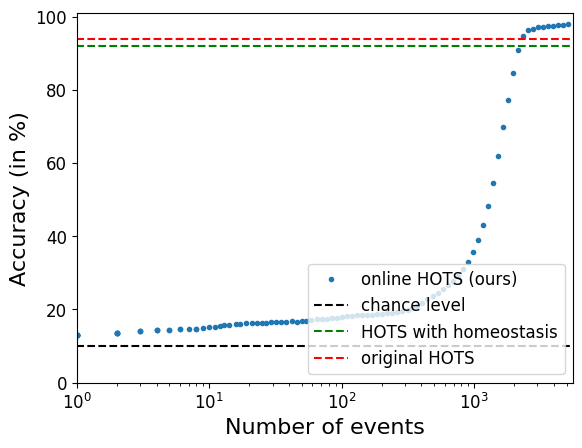

In [ ]:
mlr_threshold = None
onlinac,_,_,_ = online_accuracy(classif_layer, tau_cla, testoutputloader, results_path, ts_size, testset_output.ordering, n_classes, mlr_threshold = mlr_threshold, original_accuracy = score, original_accuracy_nohomeo = score_nohomeo, online_plot=True)

In [1]:
mlr_threshold = .99
onlinac_thres,_,_,_ = online_accuracy(classif_layer, tau_cla, testoutputloader, results_path, ts_size, testset_output.ordering, n_classes, mlr_threshold = mlr_threshold, original_accuracy = score, original_accuracy_nohomeo = score_nohomeo, online_plot=True)

NameError: name 'online_accuracy' is not defined

/tmp/ipykernel_3932566/703135736.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']*5);


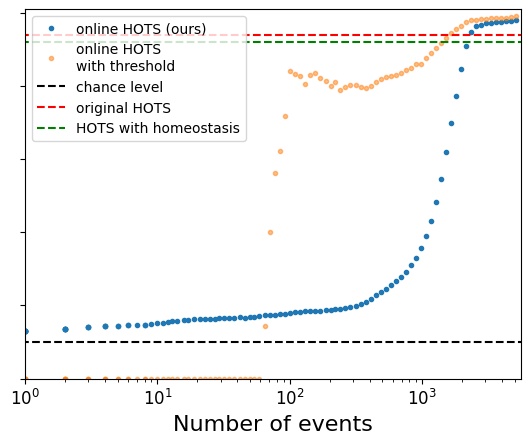

In [14]:
import matplotlib.pyplot as plt

event_90th = 5565
sampling = (np.logspace(0,np.log10(event_90th),100)).astype(int)

fig, ax = plt.subplots()
ax.semilogx(sampling[:-1],onlinac[sampling[:-1]]*100, '.', label='online HOTS (ours)');
ax.semilogx(sampling[:-1],onlinac_thres[sampling[:-1]]*100, '.', label='online HOTS \nwith threshold', alpha = .5);
ax.hlines(1/n_classes*100,0,event_90th, linestyles='dashed', color='k', label='chance level')
ax.hlines(score_nohomeo*100,0,event_90th, linestyles='dashed', color='r', label='original HOTS')
ax.hlines(score*100,0,event_90th, linestyles='dashed', color='g', label='HOTS with homeostasis')
ax.set_xlabel('Number of events', fontsize=16);
ax.axis([1,event_90th,0,101]);
#plt.title('LR classification results evolution as a function of the number of events');
plt.setp(ax.get_xticklabels(),fontsize=12)
#ax.set_yticks([])
plt.setp(ax.get_yticklabels(),fontsize=12)
#ax.set_ylabel('Accuracy (in %)', fontsize=16);
ax.legend(fontsize=10, loc='upper left');
    #printfig(fig, figure_name)
ax.set_yticklabels(['']*5);

In [15]:
name = 'nmnist_online.pdf'

dpi_exp = None
bbox = 'tight'
path = '../../manuscript/fig/'
#path = '../../GrimaldiEtAl2020HOTS_clone_laurent/fig'
fig.savefig(path+name, dpi = dpi_exp, bbox_inches=bbox, transparent=True)

## Robustness to spatial jitter (Figure 5-(b)-(up))

In [8]:
kfold_jitter = 10
nb_trials = 10
nb_points = 20
mlr_threshold = .99

trainset_output_jitter = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)

In [ ]:
hots.name = initial_name
hots_nohomeo.name = initial_name_nohomeo
standard_spatial_jitter_min = 0
standard_spatial_jitter_max = 10
apply_jitter(standard_spatial_jitter_min, standard_spatial_jitter_max, 'spatial', hots, hots_nohomeo, classif_layer, tau_cla, dataset_name, trainset_output_jitter, trainset_output_nohomeo, learning_rate ,betas ,num_epochs, filtering_threshold = filtering_threshold, kfold = kfold_jitter, nb_trials = nb_trials, nb_points = nb_points, mlr_threshold = mlr_threshold, fitting = True, verbose = True);

## Robustness to temporal jitter (Figure 5-(b)-(down))

In [ ]:
hots.name = initial_name
hots_nohomeo.name = initial_name_nohomeo
standard_temporal_jitter_min = 3
standard_temporal_jitter_max = 7
apply_jitter(standard_temporal_jitter_min, standard_temporal_jitter_max, 'temporal', hots, hots_nohomeo, classif_layer, tau_cla, dataset_name, trainset_output_jitter, trainset_output_nohomeo, learning_rate ,betas ,num_epochs, filtering_threshold = filtering_threshold, kfold = kfold_jitter, nb_trials = nb_trials, nb_points = nb_points, mlr_threshold = mlr_threshold, fitting = True, verbose = True);

In [9]:
nb_trials = 6
scores_jit = np.zeros([nb_trials, nb_points])
scores_jit_histo = np.zeros([nb_trials, nb_points])
scores_jit_histo_nohomeo = np.zeros([nb_trials, nb_points])
for trial in range(nb_trials):
    jitter_path = f'{hots.record_path}jitter_results/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_10_3_7_10_20_{trial}'
    data_stored = np.load(jitter_path+'.npz')
    jitter_values = data_stored['arr_0']
    scores_jit_single = data_stored['arr_1']
    scores_jit_histo_single = data_stored['arr_3']
    scores_jit_histo_nohomeo_single = data_stored['arr_2']
    scores_jit[trial,:] = scores_jit_single
    scores_jit_histo[trial,:] = scores_jit_histo_single
    scores_jit_histo_nohomeo[trial,:] = scores_jit_histo_nohomeo_single
jitter_values*=1e-3

In [11]:
fitting = True
logscale = True
jitter_type = 'temporal'

In [12]:
scores_jit[:,-1] += .09

/home/antoine/homhots/hotsline/hots/utils.py:624: RuntimeWarning: invalid value encountered in double_scalars
  semisat = jitter0**powa
/home/antoine/homhots/hotsline/hots/utils.py:624: RuntimeWarning: invalid value encountered in double_scalars
  semisat = jitter0**powa
/home/antoine/homhots/hotsline/hots/utils.py:624: RuntimeWarning: invalid value encountered in double_scalars
  semisat = jitter0**powa
/tmp/ipykernel_3289635/310388490.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_t.set_yticklabels(['']*10);


semi saturation level for online HOTS (ours): 114.98 ms
semi saturation level for HOTS with homeostasis: 45.35 ms
semi saturation level for original HOTS: 37.65 ms


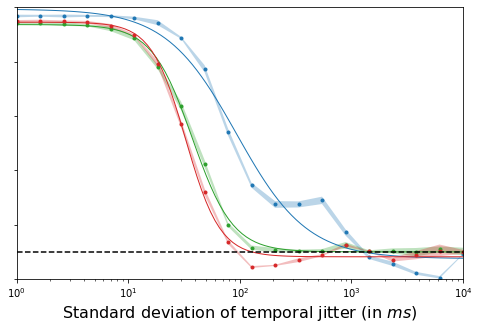

In [13]:
fig_t, ax_t = plt.subplots(1,1,figsize=(8,5))
colorz = ['#2ca02c','#1f77b4','#d62728']
label = 'online HOTS (ours)'
param_T = [.97, 1/n_classes, 2, 20] # to change to adjust the fit
n_epoch = 33

fig_t, ax_t, semisat_t = plotjitter(fig_t, ax_t, jitter_values, scores_jit, param = param_T, color=colorz[1], label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)
if fitting:
    print(f'semi saturation level for {label}: {np.round(semisat_t,2)} ms')

label = 'HOTS with homeostasis'
param_T = [.95, 1/n_classes, 2, .1] # to change to adjust the fit
fig_t, ax_t, semisat_t = plotjitter(fig_t, ax_t, jitter_values, scores_jit_histo, param = param_T, color=colorz[0], label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)
if fitting:
    print(f'semi saturation level for {label}: {np.round(semisat_t,2)} ms')

label = 'original HOTS'
param_T = [.95,1/n_classes, 2, 2] # to change to adjust the fit
fig_t, ax_t, semisat_t = plotjitter(fig_t, ax_t, jitter_values, scores_jit_histo_nohomeo, param = param_T, color=colorz[2], label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)
if fitting:
    print(f'semi saturation level for {label}: {np.round(semisat_t,2)} ms')

chance_t = np.ones([len(jitter_values)])*100/n_classes
ax_t.plot(jitter_values,chance_t, 'k--', label='chance level')
if jitter_type=='temporal':
    ax_t.axis([1,max(jitter_values),0,100]);
    ax_t.set_xlabel('Standard deviation of temporal jitter (in $ms$)', fontsize=16);
else:
    ax_t.axis([0,max(jitter_values),0,100]);
    ax_t.set_xlabel('Standard deviation of spatial jitter (in $pixels$)', fontsize=16);
#fig_t.legend(loc='upper right');
#ax_t.set_ylabel('Accuracy (in %)', fontsize=16);
ax_t.set_yticklabels(['']*10);

In [ ]:
name = 'temporal_jitter_nmnist.pdf'

dpi_exp = None
bbox = 'tight'
path = '../../manuscript/fig/'
#path = '../../GrimaldiEtAl2020HOTS_clone_laurent/fig'
fig_t.savefig(path+name, dpi = dpi_exp, bbox_inches=bbox, transparent=True)

In [24]:
nb_trials = 5
scores_jit = np.zeros([nb_trials-1, nb_points])
scores_jit_histo = np.zeros([nb_trials-1, nb_points])
scores_jit_histo_nohomeo = np.zeros([nb_trials-1, nb_points])
for trial in range(1,nb_trials):
    jitter_path = f'{hots.record_path}jitter_results/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_10_0_10_10_20_{trial}'
    data_stored = np.load(jitter_path+'.npz')
    jitter_values = data_stored['arr_0']
    scores_jit_single = data_stored['arr_1']
    scores_jit_histo_single = data_stored['arr_3']
    scores_jit_histo_nohomeo_single = data_stored['arr_2']
    scores_jit[trial-1,:] = scores_jit_single
    scores_jit_histo[trial-1,:] = scores_jit_histo_single
    scores_jit_histo_nohomeo[trial-1,:] = scores_jit_histo_nohomeo_single
#jitter_values*=1e-3

In [22]:
fitting = True
logscale = False
jitter_type = 'spatial'

In [25]:
scores_jit_histo_nohomeo

array([[0.947, 0.883, 0.781, 0.584, 0.429, 0.295, 0.212, 0.164, 0.128,
        0.117, 0.113, 0.104, 0.1  , 0.097, 0.099, 0.094, 0.091, 0.089,
        0.084, 0.085],
       [0.947, 0.877, 0.755, 0.599, 0.428, 0.297, 0.2  , 0.149, 0.131,
        0.118, 0.106, 0.106, 0.102, 0.101, 0.099, 0.093, 0.092, 0.091,
        0.085, 0.088],
       [0.947, 0.88 , 0.762, 0.61 , 0.454, 0.293, 0.211, 0.158, 0.129,
        0.115, 0.108, 0.107, 0.105, 0.101, 0.098, 0.098, 0.094, 0.087,
        0.087, 0.083],
       [0.947, 0.88 , 0.761, 0.595, 0.434, 0.314, 0.202, 0.158, 0.125,
        0.114, 0.11 , 0.105, 0.104, 0.101, 0.094, 0.1  , 0.09 , 0.088,
        0.086, 0.087]])

/home/INT/grimaldi.a/Documents/projets/HOTS/hotsline/hots/utils.py:625: RuntimeWarning: divide by zero encountered in power
  x = jitter**powa
/home/INT/grimaldi.a/Documents/projets/HOTS/hotsline/hots/utils.py:625: RuntimeWarning: overflow encountered in power
  x = jitter**powa
/home/INT/grimaldi.a/Documents/projets/HOTS/hotsline/hots/utils.py:626: RuntimeWarning: invalid value encountered in double_scalars
  semisat = jitter0**powa
/home/INT/grimaldi.a/Documents/projets/HOTS/hotsline/hots/utils.py:627: RuntimeWarning: invalid value encountered in true_divide
  output = Rmax-Rmax*x/(x+jitter0)+Rmin
/home/INT/grimaldi.a/Documents/projets/HOTS/hotsline/hots/utils.py:626: RuntimeWarning: invalid value encountered in double_scalars
  semisat = jitter0**powa
/tmp/ipykernel_2113266/1485970395.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_t.set_yticklabels(['']*10);


semi saturation level for online HOTS (ours): 4.14 ms
semi saturation level for HOTS with homeostasis: 2.22 ms
semi saturation level for original HOTS: 2.02 ms


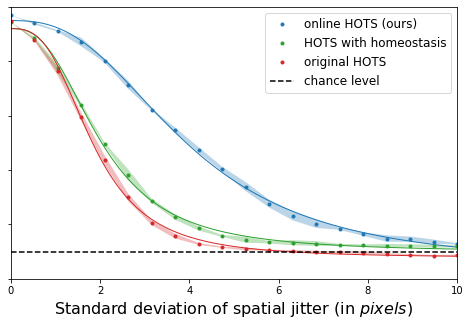

In [26]:
fig_t, ax_t = plt.subplots(1,1,figsize=(8,5))
colorz = ['#2ca02c','#1f77b4','#d62728']
label = 'online HOTS (ours)'
param_T = [.97, 1/n_classes, 2, 20] # to change to adjust the fit
n_epoch = 33

fig_t, ax_t, semisat_t = plotjitter(fig_t, ax_t, jitter_values, scores_jit, param = param_T, color=colorz[1], label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)
if fitting:
    print(f'semi saturation level for {label}: {np.round(semisat_t,2)} ms')

label = 'HOTS with homeostasis'
param_T = [.95, 1/n_classes, 2, .1] # to change to adjust the fit
fig_t, ax_t, semisat_t = plotjitter(fig_t, ax_t, jitter_values, scores_jit_histo, param = param_T, color=colorz[0], label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)
if fitting:
    print(f'semi saturation level for {label}: {np.round(semisat_t,2)} ms')

label = 'original HOTS'
param_T = [.95,1/n_classes, 2, 2] # to change to adjust the fit
fig_t, ax_t, semisat_t = plotjitter(fig_t, ax_t, jitter_values, scores_jit_histo_nohomeo, param = param_T, color=colorz[2], label=label, n_epo=n_epoch, fitting = fitting, logscale=logscale)
if fitting:
    print(f'semi saturation level for {label}: {np.round(semisat_t,2)} ms')

chance_t = np.ones([len(jitter_values)])*100/n_classes
ax_t.plot(jitter_values,chance_t, 'k--', label='chance level')
if jitter_type=='temporal':
    ax_t.axis([1,max(jitter_values),0,100]);
    ax_t.set_xlabel('Standard deviation of temporal jitter (in $ms$)', fontsize=16);
else:
    ax_t.axis([0,max(jitter_values),0,100]);
    ax_t.set_xlabel('Standard deviation of spatial jitter (in $pixels$)', fontsize=16);
ax_t.legend(fontsize=12)#loc='upper right');
#ax_t.set_ylabel('Accuracy (in %)', fontsize=16);
ax_t.set_yticklabels(['']*10);

In [29]:
name = 'spatial_jitter_nmnist.pdf'

dpi_exp = None
bbox = 'tight'
path = '../../manuscript/fig/'
#path = '../../GrimaldiEtAl2020HOTS_clone_laurent/fig'
fig_t.savefig(path+name, dpi = dpi_exp, bbox_inches=bbox, transparent=True)